In [1]:
!pip install -q torch==2.1.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --only-binary :all: 
!pip install -q transformers==4.38.2 accelerate==0.28.0 pandas scikit-learn wandb unidecode nltk seaborn tqdm emoji huggingface_hub matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 395.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import os, re, random, emoji, nltk, torch, warnings
import numpy as np, pandas as pd, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset # Added TensorDataset
from torch.optim import AdamW
import torch.optim as optim # Added optim for GRU
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
# WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")

try:
    nltk.download('punkt', quiet=True)
except Exception as e:
    print(f"Could not download nltk punkt: {e}")

warnings.filterwarnings("ignore")
login(token= HF_TOKEN)
# import wandb #not using W&B

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
class CFG:
    MODEL_NAME = "vinai/bertweet-base"
    MAX_LEN = 96
    BATCH_SIZE = 32
    NUM_EPOCHS = 10 # BERT Fine-tuning epochs (Not used for training in this script)
    LR = 2e-5
    WEIGHT_DECAY = 0.01
    NUM_WORKERS = 2 # Adjust based on your system
    SEED = 42
    WARMUP_RATIO = 0.1
    DROPOUT = 0.2
    R_DROP_ALPHA = 0.3
    LABEL_SMOOTH = 0.1
    GRAD_ACCUM = 1
    FP16 = True if DEVICE == "cuda" else False # Enable FP16 only if CUDA is available

    # Add paths for data (adjust if not running on Kaggle)
    TRAIN_CSV = "/kaggle/input/twitter-emotion-dataset2/train.csv"
    VAL_CSV = "/kaggle/input/twitter-emotion-dataset2/val.csv"
    TEST_CSV = "/kaggle/input/twitter-emotion-dataset2/test.csv"


    BERT_MODEL_FULL_PATH = "/kaggle/input/bert-fine-tuned/pytorch/default/1/bert_fine_tune.pt"
    MODEL_SAVE_PATH = "/kaggle/working/"            
    GRU_MODEL_FILENAME = "best_gru_stacking_model.pt" 
   

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(CFG.SEED)

def pre_process_document(text):
    # Handle potential non-string data
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = emoji.demojize(text) # Consider if demojize is desired or emoji removal
    text = re.sub(r"@\w+", "@user", text)
    text = re.sub(r"#(\w+)", r"\1", text) # Removes # but keeps the word
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

print("Seeding and preprocessing function defined.")

Seeding and preprocessing function defined.


In [5]:
if not os.path.exists(CFG.TRAIN_CSV):
    raise FileNotFoundError(f"Train CSV not found at {CFG.TRAIN_CSV}")
if not os.path.exists(CFG.VAL_CSV):
    raise FileNotFoundError(f"Validation CSV not found at {CFG.VAL_CSV}")
if not os.path.exists(CFG.TEST_CSV):
    raise FileNotFoundError(f"Test CSV not found at {CFG.TEST_CSV}")

train_df = pd.read_csv(CFG.TRAIN_CSV)
val_df   = pd.read_csv(CFG.VAL_CSV)
test_df  = pd.read_csv(CFG.TEST_CSV)

print("Preprocessing text data...")
train_df['text'] = train_df['text'].apply(pre_process_document)
val_df['text']   = val_df['text'].apply(pre_process_document)
test_df['text']  = test_df['text'].apply(pre_process_document)

print("Encoding labels...")
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
# Use transform only for val and test, handle potential new labels if necessary
try:
    val_df['label'] = le.transform(val_df['label'])
    test_df['label'] = le.transform(test_df['label'])
except ValueError as e:
    print(f"Warning: {e}. Check if val/test sets contain labels not present in the training set.")

NUM_CLASSES = len(le.classes_)
CLASS_NAMES = list(le.classes_)
print(f"Detected {NUM_CLASSES} emotion classes: {CLASS_NAMES}")

Preprocessing text data...
Encoding labels...
Detected 6 emotion classes: [0, 1, 2, 3, 4, 5]


In [6]:
print(f"Loading tokenizer: {CFG.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME, use_fast=True)

class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df['text'].values
        # Ensure labels are integers if they exist
        self.labels = df['label'].astype(int).values if 'label' in df else None
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        enc = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {
            'input_ids': enc['input_ids'].squeeze(0), # Remove batch dim added by tokenizer
            'attention_mask': enc['attention_mask'].squeeze(0) # Remove batch dim
        }
        if self.labels is not None:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

print("Creating BERT Datasets...")
train_ds = TweetDataset(train_df, tokenizer, CFG.MAX_LEN)
val_ds   = TweetDataset(val_df, tokenizer, CFG.MAX_LEN)
test_ds  = TweetDataset(test_df, tokenizer, CFG.MAX_LEN)

print("Creating BERT DataLoaders...")
# These loaders will be used for logit extraction
train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True) # Shuffle=False for logit extraction
val_loader   = DataLoader(val_ds,   batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)

print("BERT DataLoaders ready for logit extraction.")

Loading tokenizer: vinai/bertweet-base


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Creating BERT Datasets...
Creating BERT DataLoaders...
BERT DataLoaders ready for logit extraction.


In [7]:
class BERTweetClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(CFG.MODEL_NAME)
        self.dropout = nn.Dropout(CFG.DROPOUT)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits

# Note: Loss functions (compute_kl_loss, label_smoothing_loss) have been removed as they are not required now
# Note: train_one_epoch function is removed

# BERT Evaluation Function (kept for verifying loaded model)
@torch.no_grad()
def eval_model(model, loader, device, return_preds_labels=False):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss() # Standard CE for eval metrics

    for batch in tqdm(loader, desc="BERT Evaluating", leave=False):
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        # Check if labels exist in the batch before moving to device
        labels = batch.get('label')
        if labels is not None:
            labels = labels.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=CFG.FP16):
             outputs = model(input_ids, attention_mask)
             if labels is not None:
                 loss = criterion(outputs, labels)
                 total_loss += loss.item()

        batch_preds = outputs.argmax(dim=-1).cpu().numpy()
        all_preds.extend(batch_preds)
        if labels is not None:
            batch_labels = labels.cpu().numpy()
            all_labels.extend(batch_labels)

    # Calculate metrics only if labels were present
    avg_loss = total_loss / len(loader) if len(loader) > 0 else 0
    acc = None
    f1 = None
    if all_labels: # Check if the list is not empty
        try:
            acc = accuracy_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds, average='weighted')
        except Exception as e:
            print(f"Could not calculate metrics: {e}")

    if return_preds_labels:
        return avg_loss, acc, f1, all_preds, all_labels if all_labels else None # Return None for labels if empty
    return avg_loss, acc, f1

print("BERT Model definition and evaluation function ready.")

BERT Model definition and evaluation function ready.


In [8]:
bert_model_full_path = CFG.BERT_MODEL_FULL_PATH
print(f"\nLoading PRE-TRAINED BERT model from {bert_model_full_path} for verification and logit extraction...")

bert_model_for_logits = None 
try:
    if not os.path.exists(bert_model_full_path):
         raise FileNotFoundError(f"Model file not found at {bert_model_full_path}. Please ensure the model file '{CFG.BERT_MODEL_FILENAME}' is correctly uploaded to the '/kaggle/input/models/' directory.")

    bert_model_for_logits = BERTweetClassifier(NUM_CLASSES).to(DEVICE) 
    bert_model_for_logits.load_state_dict(torch.load(bert_model_full_path, map_location=DEVICE))
    bert_model_for_logits.eval() # Set to evaluation mode
    print(f"Pre-trained BERT model loaded successfully from {bert_model_full_path}")

    # --- Optional Verification Step ---
    print("\nVerifying loaded BERT model on the test set...")
    # Use the test_loader created earlier
    test_loss, test_acc, test_f1, bert_test_preds, bert_test_labels = eval_model(
        bert_model_for_logits, test_loader, DEVICE, return_preds_labels=True
    )
    if test_acc is not None and test_f1 is not None:
        print(f"\n✅ Loaded BERT Model Test Results:")
        print(f"   Test Loss: {test_loss:.4f}")
        print(f"   Test Acc:  {test_acc:.4f}")
        print(f"   Test F1:   {test_f1:.4f}")
    else:
        print("   Verification metrics could not be calculated (likely missing test labels).")
    # --- End Verification Step ---

except FileNotFoundError as e:
    print(f"{e}")
    bert_model_for_logits = None # Ensure model is None if loading failed
    bert_test_preds, bert_test_labels = None, None
except Exception as e:
    print(f"An error occurred loading the pre-trained BERT model: {e}")
    bert_model_for_logits = None
    bert_test_preds, bert_test_labels = None, None

# Assign to seed_models list for consistency with GRU code structure
seed_models = [bert_model_for_logits] if bert_model_for_logits else []
print(f"Total base models loaded for logit extraction: {len(seed_models)}")


Loading PRE-TRAINED BERT model from /kaggle/input/bert-fine-tuned/pytorch/default/1/bert_fine_tune.pt for verification and logit extraction...


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Pre-trained BERT model loaded successfully from /kaggle/input/bert-fine-tuned/pytorch/default/1/bert_fine_tune.pt

Verifying loaded BERT model on the test set...



✅ Loaded BERT Model Test Results:
   Test Loss: 0.1414
   Test Acc:  0.9702
   Test F1:   0.9701
Total base models loaded for logit extraction: 1


In [9]:
@torch.no_grad()
def collect_logits(model, loader, device):
    """ Collects raw logits from a given model and dataloader. """
    model.eval() 
    model_logits = []
    print(f"Collecting logits using device: {device}")
    for batch in tqdm(loader, desc=f"Collecting logits"):
        # Move data to the correct device
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        # Handle FP16 if enabled and device is CUDA
        with torch.cuda.amp.autocast(enabled=(CFG.FP16 and device=='cuda')):
            logits = model(input_ids, attention_mask)

        # Append logits (move back to CPU if they were on CUDA)
        model_logits.append(logits.cpu().numpy())

    
    if not model_logits:
        raise ValueError("No logits were collected. The loader might be empty.")

    return np.concatenate(model_logits, axis=0)

print("Logit collection function defined.")

Logit collection function defined.


In [10]:
X_train_seq, X_val_seq, X_test_seq = None, None, None
y_train, y_val, y_test = None, None, None

if seed_models and seed_models[0] is not None:
    print("\nCollecting logits from the loaded BERT model...")
    try:
        all_train_logits = [collect_logits(m, train_loader, DEVICE) for m in seed_models]
        all_val_logits   = [collect_logits(m, val_loader, DEVICE) for m in seed_models]
        all_test_logits  = [collect_logits(m, test_loader, DEVICE) for m in seed_models]

        #Stack logits along axis=1. Shape will be (N, 1, num_classes)
        X_train_seq = np.stack(all_train_logits, axis=1)
        X_val_seq   = np.stack(all_val_logits, axis=1)
        X_test_seq  = np.stack(all_test_logits, axis=1)
        y_train = train_df['label'].values
        y_val   = val_df['label'].values
        y_test  = test_df['label'].values

        print(f"Logits collected successfully.")
        print(f"GRU training input shape:   {X_train_seq.shape}, Labels shape: {y_train.shape}")
        print(f"GRU validation input shape: {X_val_seq.shape}, Labels shape: {y_val.shape}")
        print(f"GRU test input shape:       {X_test_seq.shape}, Labels shape: {y_test.shape}")

    except ValueError as e:
        print(f"Error during logit collection or stacking: {e}")
        X_train_seq, X_val_seq, X_test_seq = None, None, None # Reset on error
        y_train, y_val, y_test = None, None, None
    except Exception as e:
         print(f"An unexpected error occurred during logit processing: {e}")
         X_train_seq, X_val_seq, X_test_seq = None, None, None # Reset on error
         y_train, y_val, y_test = None, None, None

else:
    print("Base BERT model was not loaded successfully, skipping GRU logit collection and stacking.")

Logits collected successfully.
GRU training input shape:   (52109, 1, 6), Labels shape: (52109,)
GRU validation input shape: (7445, 1, 6), Labels shape: (7445,)
GRU test input shape:       (14888, 1, 6), Labels shape: (14888,)


In [11]:
class EnsembleGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,         #Should be NUM_CLASSES (features per time step)
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,              #Input shape: (batch, seq_len, features)
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0 # Apply dropout between GRU layers
        )
        # Dropout after GRU layers but before the final linear layer
        self.dropout_layer = nn.Dropout(dropout)
        # Input features for Linear layer = hidden_size * 2 (because bidirectional)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len=num_models, features=num_classes)
        gru_out, _ = self.gru(x)
        # gru_out shape: (batch, seq_len, num_directions * hidden_size)

        # We want the final hidden state's output. For batch_first=True, this is gru_out[:, -1, :]
        last_time_step_output = gru_out[:, -1, :]

        # Apply dropout
        out = self.dropout_layer(last_time_step_output)

        # Pass through the final fully connected layer
        logits = self.fc(out)
        return logits

def make_loader(X, y, batch_size=32, shuffle=True):
    """Creates a DataLoader for GRU input."""
    if X is None or y is None:
        print(f"Warning: Input data (X or y) is None for make_loader. Returning None.")
        return None
    try:
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        dataset = TensorDataset(X_tensor, y_tensor)
        num_workers = getattr(CFG, 'NUM_WORKERS', 0) if getattr(CFG, 'NUM_WORKERS', 0) > 0 else 0
        pin_mem = (DEVICE == 'cuda') # Use pin_memory only if using CUDA
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_mem)
    except Exception as e:
        print(f"Error creating DataLoader: {e}")
        return None

# Create DataLoaders only if logit collection was successful
gru_train_loader, gru_val_loader, gru_test_loader = None, None, None
if X_train_seq is not None and y_train is not None:
    print("Creating GRU DataLoaders...")
    gru_train_loader = make_loader(X_train_seq, y_train, batch_size=CFG.BATCH_SIZE, shuffle=True)
    gru_val_loader   = make_loader(X_val_seq, y_val, batch_size=CFG.BATCH_SIZE, shuffle=False)
    gru_test_loader  = make_loader(X_test_seq, y_test, batch_size=CFG.BATCH_SIZE, shuffle=False)
    if gru_train_loader and gru_val_loader and gru_test_loader:
        print("GRU DataLoaders created successfully.")
    else:
         print("Failed to create one or more GRU DataLoaders.")
else:
    print("GRU DataLoaders not created as logit data (X or y) is missing.")

print("Ensemble GRU Classifier and DataLoader function defined.")

Creating GRU DataLoaders...
GRU DataLoaders created successfully.
Ensemble GRU Classifier and DataLoader function defined.


In [12]:
def train_gru_epoch(model, loader, criterion, optimizer, device, scaler, use_amp=False):
    model.train()
    total_loss, correct, total = 0, 0, 0
    if loader is None:
        print("Skipping GRU training epoch: loader is None.")
        return 0.0, 0.0

    for X, y in tqdm(loader, desc="GRU Training", leave=False):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Use autocast for mixed precision if enabled
        with torch.cuda.amp.autocast(enabled=use_amp):
            out = model(X)
            loss = criterion(out, y)

        if torch.isnan(loss):
            print(f"NaN loss detected during training. Skipping batch. Input shape: {X.shape}")
            continue

        # Scale loss and backpropagate if using AMP
        if use_amp:
            scaler.scale(loss).backward()
            # Optional: Gradient Clipping (before scaler.step)
            # scaler.unscale_(optimizer) # Unscale gradients before clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            # Optional: Gradient Clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_loss += loss.item() * X.size(0)
        total += X.size(0)

    # Avoid division by zero if loader was empty or all batches had NaN loss
    if total == 0:
        return 0.0, 0.0
    return total_loss / total, correct / total

@torch.no_grad()
def eval_gru_epoch(model, loader, criterion, device, use_amp=False):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds_all, labels_all = [], []
    if loader is None:
        print("Skipping GRU evaluation epoch: loader is None.")
        return 0.0, 0.0, np.array([]), np.array([])

    for X, y in tqdm(loader, desc="GRU Evaluating", leave=False):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            out = model(X)
            loss = criterion(out, y)

        if torch.isnan(loss):
             print(f"NaN loss detected during evaluation. Skipping batch. Input shape: {X.shape}")
             continue

        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_loss += loss.item() * X.size(0)
        total += X.size(0)
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(y.cpu().numpy())

    if total == 0:
        return 0.0, 0.0, np.array(preds_all), np.array(labels_all)
    return total_loss / total, correct / total, np.array(preds_all), np.array(labels_all)

print("GRU training and evaluation functions defined.")

GRU training and evaluation functions defined.


In [13]:
# Check if necessary components are available
if X_train_seq is not None and gru_train_loader and gru_val_loader:
    print("\n🚀 Initializing and Training GRU Stacking Model...")

    gru_model = EnsembleGRUClassifier(
        input_size=NUM_CLASSES,  # Features per timestep = num classes from BERT
        hidden_size=128,         # Size of GRU hidden state
        num_layers=2,            # Number of stacked GRU layers
        num_classes=NUM_CLASSES, # Final output size
        dropout=0.4              # Dropout probability
    ).to(DEVICE)

    gru_criterion = nn.CrossEntropyLoss() # Standard loss for classification
    gru_optimizer = optim.AdamW(gru_model.parameters(), lr=1e-4, weight_decay=1e-5) # AdamW optimizer
    gru_scheduler = optim.lr_scheduler.ReduceLROnPlateau(gru_optimizer, mode='max', factor=0.2, patience=3, verbose=True) # LR scheduler
    gru_scaler = torch.cuda.amp.GradScaler(enabled=CFG.FP16) # GradScaler for mixed precision

    gru_epochs = 20 # Number of epochs to train the GRU
    best_gru_val_acc = 0.0 # Track best validation accuracy
    gru_model_full_path = os.path.join(CFG.MODEL_SAVE_PATH, CFG.GRU_MODEL_FILENAME)
    patience_counter = 0
    patience_limit = 5 #Early stopping patience

    print(f"GRU Model Parameters: {sum(p.numel() for p in gru_model.parameters()):,}")

    for epoch in range(1, gru_epochs + 1):
        
        train_loss, train_acc = train_gru_epoch(
            gru_model, gru_train_loader, gru_criterion, gru_optimizer, DEVICE, gru_scaler, use_amp=CFG.FP16
        )

        
        val_loss, val_acc, _, _ = eval_gru_epoch(
            gru_model, gru_val_loader, gru_criterion, DEVICE, use_amp=CFG.FP16
        )

        print(f"Epoch {epoch}/{gru_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Step the scheduler based on validation accuracy
        gru_scheduler.step(val_acc)

        # Save model if validation accuracy improves
        if val_acc > best_gru_val_acc:
            best_gru_val_acc = val_acc
            print(f"Best validation accuracy improved to {best_gru_val_acc:.4f}. Saving model to {gru_model_full_path}")
            torch.save(gru_model.state_dict(), gru_model_full_path)
            patience_counter = 0 
        else:
            patience_counter += 1
            print(f"   Validation accuracy did not improve. Patience: {patience_counter}/{patience_limit}")
            if patience_counter >= patience_limit:
                print("Early stopping triggered.")
                break 

    print("\nGRU Training finished.")

    # Load the best performing model for final evaluation
    try:
        if os.path.exists(gru_model_full_path):
            print(f"Loading best GRU model based on validation accuracy from {gru_model_full_path}")
            gru_model.load_state_dict(torch.load(gru_model_full_path, map_location=DEVICE))
            print("✅ Best GRU model loaded.")
        else:
            print(f"Warning: Best GRU model file not found at {gru_model_full_path}. Using the model from the last epoch.")
    except Exception as e:
        print(f"Error loading best GRU model: {e}. Using the model from the last epoch.")

else:
    print("GRU training skipped as required data or loaders were not available.")
    gru_model = None # Ensure gru_model is None if training skipped


🚀 Initializing and Training GRU Stacking Model...
GRU Model Parameters: 402,438


Epoch 1/20 | Train Loss: 0.2435, Acc: 0.9704 | Val Loss: 0.0860, Acc: 0.9713
Best validation accuracy improved to 0.9713. Saving model to /kaggle/working/best_gru_stacking_model.pt


Epoch 2/20 | Train Loss: 0.0565, Acc: 0.9775 | Val Loss: 0.0877, Acc: 0.9710
   Validation accuracy did not improve. Patience: 1/5


Epoch 3/20 | Train Loss: 0.0559, Acc: 0.9772 | Val Loss: 0.0886, Acc: 0.9714
Best validation accuracy improved to 0.9714. Saving model to /kaggle/working/best_gru_stacking_model.pt


Epoch 4/20 | Train Loss: 0.0552, Acc: 0.9775 | Val Loss: 0.0875, Acc: 0.9718
Best validation accuracy improved to 0.9718. Saving model to /kaggle/working/best_gru_stacking_model.pt


Epoch 5/20 | Train Loss: 0.0546, Acc: 0.9775 | Val Loss: 0.0876, Acc: 0.9711
   Validation accuracy did not improve. Patience: 1/5


Epoch 6/20 | Train Loss: 0.0544, Acc: 0.9775 | Val Loss: 0.0881, Acc: 0.9719
Best validation accuracy improved to 0.9719. Saving model to /kaggle/working/best_gru_stacking_model.pt


Epoch 7/20 | Train Loss: 0.0541, Acc: 0.9778 | Val Loss: 0.0880, Acc: 0.9713
   Validation accuracy did not improve. Patience: 1/5


Epoch 8/20 | Train Loss: 0.0545, Acc: 0.9775 | Val Loss: 0.0870, Acc: 0.9719
   Validation accuracy did not improve. Patience: 2/5


Epoch 9/20 | Train Loss: 0.0544, Acc: 0.9774 | Val Loss: 0.0872, Acc: 0.9717
   Validation accuracy did not improve. Patience: 3/5


Epoch 10/20 | Train Loss: 0.0542, Acc: 0.9776 | Val Loss: 0.0880, Acc: 0.9714
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
   Validation accuracy did not improve. Patience: 4/5


Epoch 11/20 | Train Loss: 0.0536, Acc: 0.9779 | Val Loss: 0.0872, Acc: 0.9718
   Validation accuracy did not improve. Patience: 5/5
Early stopping triggered.

GRU Training finished.
Loading best GRU model based on validation accuracy from /kaggle/working/best_gru_stacking_model.pt
✅ Best GRU model loaded.



Evaluating Best GRU model on the test set...



✅ GRU Stacking Model Test Results:
   Test Loss: 0.0932
   Test Acc:  0.9701
   Test F1:   0.9700

Plotting GRU Test Confusion Matrix...


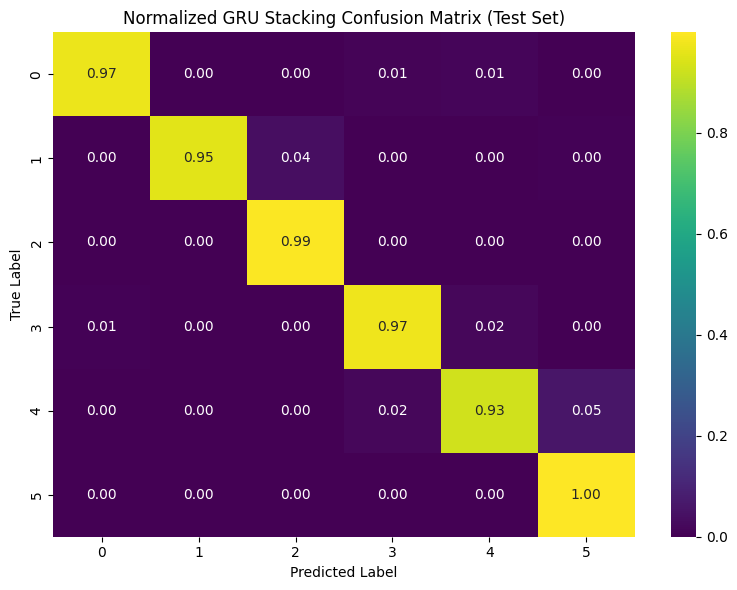

In [14]:
# Evaluate the final (best loaded) GRU model on the test set
if gru_model and gru_test_loader:
    print("\nEvaluating Best GRU model on the test set...")
    gru_test_loss, gru_test_acc, gru_test_preds, gru_test_labels = eval_gru_epoch(
        gru_model, gru_test_loader, gru_criterion, DEVICE, use_amp=CFG.FP16
    )

    # Ensure CLASS_NAMES is available from Cell 5
    if 'CLASS_NAMES' in globals() and gru_test_labels is not None and len(gru_test_labels) > 0:
        try:
            gru_test_f1 = f1_score(gru_test_labels, gru_test_preds, average='weighted')
            print(f"\n✅ GRU Stacking Model Test Results:")
            print(f"   Test Loss: {gru_test_loss:.4f}")
            print(f"   Test Acc:  {gru_test_acc:.4f}")
            print(f"   Test F1:   {gru_test_f1:.4f}")

            # Plotting the confusion matrix for the GRU model
            print("\nPlotting GRU Test Confusion Matrix...")
            cm_gru = confusion_matrix(gru_test_labels, gru_test_preds, normalize='true') # Normalize

            plt.figure(figsize=(8, 6))
            sns.heatmap(
                cm_gru,
                annot=True, fmt='.2f', cmap='viridis', # Changed colormap
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES
            )
            plt.title('Normalized GRU Stacking Confusion Matrix (Test Set)')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.tight_layout() # Adjust layout
            plt.savefig("gru_confusion_matrix.png") # Save the plot
            plt.show()
        except Exception as e:
            print(f"Error calculating F1 score or plotting confusion matrix: {e}")
            print(f"\nGRU Test Accuracy: {gru_test_acc:.4f}")

    else:
        print("CLASS_NAMES not defined or test labels missing. Cannot calculate F1 or plot confusion matrix with labels.")
        print(f"\nGRU Test Accuracy: {gru_test_acc:.4f}")

else:
    print("GRU evaluation skipped as the model or test loader was not available.")